In [1]:
from finlab.data import Data
data = Data()

# 條件一：公司的市值

In [2]:
# 先拿出計算市值需要用到的財務數據

股本 = data.get('股本合計', 1)
price = data.get('收盤價', 100)

In [3]:

# ----------- #
# 找出當天股價  #
# ----------- #

# 新版（較簡單）：將頻率為「天」的股價，reindex 成每「季」
# method='fill'是說，假如公佈財報那天沒有股價，則以時間往前最接近的那天為主。

當天股價 = price.reindex(股本.index, method='ffill').iloc[-1]

# 原本（較難）：當天股價 = price.loc[:股本.index[0]].iloc[-1]

# ----------- #
# 找出當天股本  #
# ----------- #

當天股本 = 股本.iloc[-1]

# -----------  #
# 計算市值      #
# -----------  #

# 市值 = 總股數 * 股價
#     = （股本 * 1000） / 10 * 股價

市值 = 當天股本 * 1000 / 10 * 當天股價
市值['1101']

184723141500.0

# 條件二：自由現金流

In [4]:
import pandas as pd

# 將每季累計的財務數據，轉換成單季
def toSeasonal(df):
    season4 = df[df.index.month == 3]
    season1 = df[df.index.month == 5]
    season2 = df[df.index.month == 8]
    season3 = df[df.index.month == 11]

    season1.index = season1.index.year
    season2.index = season2.index.year
    season3.index = season3.index.year
    season4.index = season4.index.year - 1

    newseason1 = season1
    newseason2 = season2 - season1.reindex_like(season2)
    newseason3 = season3 - season2.reindex_like(season3)
    newseason4 = season4 - season3.reindex_like(season4)

    newseason1.index = pd.to_datetime(newseason1.index.astype(str) + '-05-15')
    newseason2.index = pd.to_datetime(newseason2.index.astype(str) + '-08-14')
    newseason3.index = pd.to_datetime(newseason3.index.astype(str) + '-11-14')
    newseason4.index = pd.to_datetime((newseason4.index + 1).astype(str) + '-03-31')

    return newseason1.append(newseason2).append(newseason3).append(newseason4).sort_index()
    
# 計算自由現金流 = 營業活動之淨現金流入 - 投資活動之淨現金流出
投資現金流 = toSeasonal(data.get('投資活動之淨現金流入（流出）', 8))
營業現金流 = toSeasonal(data.get('營業活動之淨現金流入（流出）', 8))
自由現金流 = (投資現金流 + 營業現金流).iloc[-4:].sum()
自由現金流.describe()

count    8.530000e+02
mean     1.161948e+06
std      1.403177e+07
min     -1.384047e+08
25%     -2.252450e+05
50%      7.269200e+04
75%      6.172730e+05
max      2.846422e+08
dtype: float64

# 條件三：股東權益報酬率

In [16]:
稅後淨利 = data.get('本期淨利（淨損）', 1)

# 修正：因為有些股東權益的名稱叫作「權益總計」有些叫作「權益總額」，所以要先將這兩個dataframe合併起來喔！
權益總計 = data.get('權益總計', 1)
權益總額 = data.get('權益總額', 1)

# 把它們合併起來（將「權益總計」為NaN的部分填上「權益總額」）
權益總計.fillna(權益總額, inplace=True)

股東權益報酬率 = 稅後淨利.iloc[-1] / 權益總計.iloc[-1]
股東權益報酬率.describe()

count    821.000000
mean      -0.011035
std        0.556228
min      -15.538886
25%       -0.001523
50%        0.011325
75%        0.026841
max        1.856361
Name: 2018-05-15 00:00:00, dtype: float64

# 條件四：營業利益成長率

In [12]:
# 影片中打錯了，這裡才是對的喔！
營業利益 = data.get('營業利益（損失）', 5)
營業利益成長率 = (營業利益.iloc[-1] / 營業利益.iloc[-5] - 1) * 100
營業利益成長率.describe()

count       801.000000
mean       -430.477335
std       11941.207268
min     -313580.000000
25%         -62.345581
50%         -13.207170
75%          25.081366
max       91821.428571
dtype: float64

# 條件五：市值營收比

In [13]:
%matplotlib inline
當月營收 = data.get('當月營收', 4) * 1000
當季營收 = 當月營收.iloc[-4:].sum() # 取近4個月營收總和，當作一季的月營收（4也可以改變）
市值營收比 = 市值 / 當季營收
市值營收比.describe()

count       824.000000
mean        227.567248
std        6287.777988
min         -19.771431
25%           1.996592
50%           3.461603
75%           6.292128
max      180500.268750
dtype: float64

# 結合上述五個條件選股

In [14]:
condition1 = (市值 < 10000000000)
condition2 = 自由現金流 > 0
condition3 = 股東權益報酬率 > 0
condition4 = 營業利益成長率 > 0
condition5 = 市值營收比 < 5

# 將條件做交集（&）
select_stock = condition1 & condition2 & condition3 & condition4 & condition5 

# 選出的股票
select_stock[select_stock]

stock_id
1109    True
1231    True
1309    True
1323    True
1414    True
1533    True
1604    True
1608    True
1614    True
1615    True
1701    True
1712    True
1727    True
1730    True
1733    True
1817    True
2028    True
2032    True
2365    True
2401    True
2414    True
2415    True
2430    True
2472    True
2480    True
2493    True
2546    True
2601    True
2636    True
2642    True
2731    True
3029    True
3056    True
4722    True
4755    True
4916    True
4968    True
5515    True
6112    True
6168    True
6281    True
8070    True
8374    True
8940    True
9911    True
dtype: bool

# 綜合上述，優等生策略：mystrategy

In [3]:
import pandas as pd

def mystrategy(data):
    
    股本 = data.get('股本合計', 1)
    price = data.get('收盤價', 120)
    當天股價 = price[:股本.index[-1]].iloc[-1]
    當天股本 = 股本.iloc[-1]
    市值 = 當天股本 * 當天股價 / 10 * 1000
   

    df1 = toSeasonal(data.get('投資活動之淨現金流入（流出）', 5))
    df2 = toSeasonal(data.get('營業活動之淨現金流入（流出）', 5))
    自由現金流 = (df1 + df2).iloc[-4:].mean()
    
    
    稅後淨利 = data.get('本期淨利（淨損）', 1)
    
    # 股東權益，有兩個名稱，有些公司叫做權益總計，有些叫做權益總額
    # 所以得把它們抓出來
    權益總計 = data.get('權益總計', 1)
    權益總額 = data.get('權益總額', 1)
    
    # 並且把它們合併起來
    權益總計.fillna(權益總額, inplace=True)
        
    股東權益報酬率 = 稅後淨利.iloc[-1] / 權益總計.iloc[-1]
    
    
    營業利益 = data.get('營業利益（損失）', 5)
    營業利益成長率 = (營業利益.iloc[-1] / 營業利益.iloc[-5] - 1) * 100
    
    
    當月營收 = data.get('當月營收', 4) * 1000
    當季營收 = 當月營收.iloc[-4:].sum()
    市值營收比 = 市值 / 當季營收
    
    
    condition1 = (市值 < 1e10)
    condition2 = 自由現金流 > 0
    condition3 = 股東權益報酬率 > 0
    condition4 = 營業利益成長率 > 0
    condition5 = 市值營收比 < 5
    
    select_stock = condition1 & condition2 & condition3 & condition4 & condition5
    
    return select_stock[select_stock]


# 回測

2017-01-01 - 2017-03-02 報酬率 6.74952841159 % nstock 127
2017-03-02 - 2017-05-01 報酬率 3.11076319514 % nstock 126
2017-05-01 - 2017-06-30 報酬率 2.51216452782 % nstock 102
2017-06-30 - 2017-08-29 報酬率 1.77754736697 % nstock 83
2017-08-29 - 2017-10-28 報酬率 4.08807603354 % nstock 82
2017-10-28 - 2017-12-27 報酬率 4.00637799055 % nstock 82
2017-12-27 - 2018-02-25 報酬率 1.13919205955 % nstock 84
2018-02-25 - 2018-04-26 報酬率 2.46658684976 % nstock 82


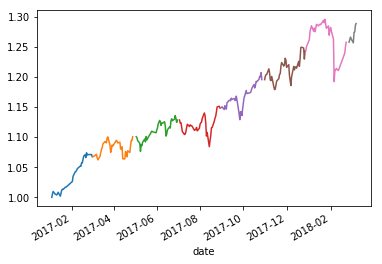

In [4]:
from finlab.backtest import backtest
from finlab.data import Data
import datetime

%matplotlib inline
data = Data()
backtest(datetime.date(2017,1,1), datetime.date(2018,3,10), 60, mystrategy, data)